<center> 
    <h1>Font Generation using Conditional GANs (CGANs)</h1>
</center>

<h2>Why CGANs?</h2>
<a href="https://arxiv.org/pdf/1406.2661.pdf", target="_blank"/>Vanilla GAN</a> was introduced in 2014 as a novel way to train generative models. We saw earlier in the labs how Generator and Discriminator play minimax game such that the generator starts to generate images close to the training distribution. <br>
However, as we saw in lab2 and lab3 that the generated data are random i.e. given a random noise as an input to the pre-trained generator, it generates random images close to the training distribution (random handwritten digits from 0-9 in case of MNIST trining dataset and Alphabet characters from AtoZ in case of Alphabets training data). This means we cannot control the generated image. 
<br>
<br>
<b>Solution => Conditional GANs</b>
<br>
<br>
Soon after the GANs paper, <a href="https://arxiv.org/pdf/1411.1784.pdf", target="_blank"/>CGAN paper</a> came out that actually solved GANs problem of random image generation. They showed a way that how GANs can generate images given some condition. Quoting from their paper: <br>"<i>In this work we introduce the conditional version of generative adversarial nets, which can be constructed by simply feeding the data, y, we wish to condition on to both the generator and discriminator. We show that this model can generate MNIST digits conditioned on class labels</i>."
<br>
CGAN for this lab is demonstrated below. 
<br>
<br>
<img src="../Figures/CGAN.png" width=800 height=800 />

<br>
<br>
In this lab we will create our own CDCGAN version to actually controll the generated images. We will train our DCGAN from last lab and modify it to become a conditional version. We will use our own alphabets dataset as used in the previous lab.
<br>



<h2> Lab Overview </h2>
This lab uses our custom font alphabet dataset and trains a CDCGAN on it to later generate controllable font characters. Following are the key points we will cover in this lab.
<ol>
    <li>Importing required libraries </li>
    <li>Dataset preparation and loading</li>
    <li>Network architecture</li>
    <li>Loss and optimizer</li>
    <li>Training</li>
    <li>Generating alphabets given a character label</li>
</ol>
    
    

<h2>Importing required libraries</h2>
Let's import the required libraries for this lab.

In [1]:
import tensorflow as tf
tf.__version__

'2.1.0'

In [2]:
# Importing other modules required for this lab
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
import time
import pathlib
from  tensorflow.keras.initializers  import  RandomNormal 

from IPython import display

total_characters = 26

<h2>Dataset preparation and loading</h2>
We saw last time how our "lab2-dataset-generator.py" module generates images that we used for training our previous two models. However, we can not use the same module for this lab because we need additional data which is the label i.e. character label of each image such that the model can differentiate between all 26 characters.<br> 
The easiest and reliable way is to represent each character as a number and then later convert the number into onehot vector representing each character. For this we have designed a module which is very similar to the previous module however, labels are stored as the image name.
Open the terminal and run the below command to generate dataset for this lab (lab3). Make sure to activate your environment, <b>tutorial-TF</b> in our case. <br><br>
<code>python ./data_generation/tools/Lab3_CDCGAN/lab3-dataset-generator.py</code><br><br>
This will create a new directory in root with name "lab3-image-data/font-images" containing (64,64) dimensional images which we will use for training our CDCGAN. The important change is that the image names have the labels "n_m.png" where, n represents the style of the font and m represents the character i.e. m=1 for A, m=2 for B, m=3 for C, etc.<br>
<b>Note</b> It will generate x*26 number of images where x is the total number of fonts in our fonts directory and 26 are the total number of character labels in the labels directory. 

Ok so far so good. Lets create an input pipeline in TensorFlow to load the data for our model. We will utilize the <a href="https://www.tensorflow.org/api_docs/python/tf/data/Dataset" target="_blank">Dataset api</a> which is an API for input pipelines in TensorFlow. <br>
First we will setup the path of the image directory by running the below code.  

In [3]:
# Setting up paths for the input images
SCRIPT_PATH = os.path.join(os.getcwd())
path_to_img_dir = os.path.join(SCRIPT_PATH, '../lab3-image-data/font-images/')

In [4]:
# Counting the total number of font images on our image directory
data_dir = pathlib.Path(path_to_img_dir)
image_count = len(list(data_dir.glob('*.png')))
print(image_count)

78


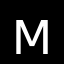

In [5]:
# Let's display out any random image from the image direcotory
images = list(data_dir.glob('*'))
PIL.Image.open(str(images[4]))

So far we have the list of all the paths of the images however our tensorflow model doesnt need this. For this we need to convert these paths into numpy array format so that we can pass it to the model later. For this, below we create a function that will return us all the images as a numpy array with a dimension <b>64x64x1</b>.

In [6]:
# Given a path below functions extracts the name of the file from it
def get_name(path):
    name, typeis = os.path.splitext(os.path.basename(path))
    return name

# get_imgs_labels(path) takes the path of the image directory and returns a list containg all images full paths.  
# The return type is <class 'list'>
# Then we take individual path from the list and create a numpy array with desired size
def get_imgs_labels(input_dir):
    if input_dir is None or not os.path.exists(input_dir):
        raise Exception("input_dir does not exist")

    input_paths = glob.glob(os.path.join(input_dir, "*.png"))

    if len(input_paths) == 0:
        raise Exception("input_dir contains no image files")

    # if the image names are numbers, sort by the value rather than asciibetically
    # having sorted inputs means that the outputs are sorted in test mode
    input_paths = sorted(input_paths, key=lambda path: int(get_name(path)))

    # Preprocess individual path and convert into numpy array with desired size
    training_images = []
    training_label = []
    for path in input_paths:
        # Preprocessing character label
        # Getting the character label m from the file name of image
        name, typeis = os.path.splitext(os.path.basename(path))
        character_name = name.split('_')[1]
        # Preprocessing image
        image = PIL.Image.open(path).resize((64,
                64),PIL.Image.ANTIALIAS)
        # Appending labels and images into a list
        training_label.append(np.asarray(character_name))
        training_images.append(np.asarray(image))
    training_label = np.reshape(training_label,(-1))
    training_images = np.reshape(training_images,(-1,64,64,1))
  
    return np.asarray(training_images), np.asarray(training_label)

In [7]:
# call the function to get all images and their labels into desired type and dimension
train_images, train_labels = get_imgs_labels(data_dir)

In [8]:
# Lets reshape and normalize the images
train_images = train_images.reshape(train_images.shape[0], 64,64,1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

# Lets reshape and convert the labels into onehot vectors
train_labels = train_labels.astype("int64")
train_labels = tf.one_hot(train_labels, depth=total_characters)
# Lets print the shapes of images and labels
print(train_images.shape)
print(train_labels.shape)

(78, 64, 64, 1)
(78, 26)


In [9]:
# This is where we use the dataset Api. We call a batch of data according to our Batch size
BUFFER_SIZE = 60000
BATCH_SIZE = 32

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE)

So far so good. So in summary above we created our dataset pipeline using tf.data api. We created a function to get all the images and their labels in numpy array format, then we reshaped them and applied preprocessing . Then we called <b>tf.data.Dataset.from_tensor_slices()</b> to actually get the input data for our model. 

<h2>Network architecture</h2>

So now let's build our model. We will be using the exactly same DCGAN we created in the last lab however, the only difference this time is the input to the Generator and the Discriminator.<br><br>
<b>Generator</b>
<br>
In generators case last time we only used noise as an input however this time we will concatenate the character label with the noise. Therefore, as shown below the input shape to the first Fully connected layer of the generator is the summation of random noise 100 + total_characters where total_characters = 26. 

In [10]:
def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(4*4*256,activation="relu",input_shape=(100+total_characters,)))
    model.add(layers.Reshape((4,4,256)))

    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(256,kernel_size=3,padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation("relu"))

    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(256,kernel_size=3,padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(128,kernel_size=3,padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation("relu"))

    model.add(layers.UpSampling2D(size=(2,2)))
    model.add(layers.Conv2D(128,kernel_size=3,padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation("relu"))

    # Final CNN layer
    model.add(layers.Conv2D(1,kernel_size=3,padding="same"))
    model.add(layers.Activation("tanh"))

    return model

Lets pass a random noise concatenated with character A's label and see what our untrained Generator outputs

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              520192    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 256)         590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 256)         1024      
_________________________________________________________________
activation (Activation)      (None, 8, 8, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 256)       0

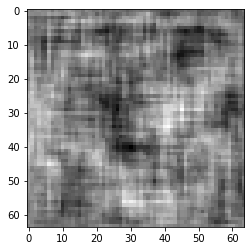

In [11]:
generator = make_generator_model()
# below shows the network architecture summary
generator.summary()

# Sample random noise from uniform distribution with shape as below
noise = tf.random.normal([1, 100])

# Prepare onehot label to concatenate with the above noise
# int_labels represents the character no. 1 means A here.
int_labels = 1
# convert into onehot representation.
y_train = keras.utils.to_categorical(int_labels, num_classes=total_characters)
# reshape to make the 0 index of y_train equal to noise which is 1.
y_train = y_train.reshape(1, total_characters)

# Debugging #
print("label shape is", y_train.shape)
print()
print("noise shape is", noise.shape)
print()

# Now concatenate both on last axis.
noise_label = np.concatenate((noise, y_train), axis=-1)
print('concat shape', noise_label.shape)

# pass the concatenated input to the generator.
generated_image = generator(noise_label, training=False)

# Plot the result.
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

<b>Discriminator</b>
<br>
The discriminator is also similar to the one we saw in the last lab however, we again need to pass it the concatenated input i.e. input image concatenated with its corresponding label on the last axis (channel in this case). As seen below the input_shape variable has 1+total_character at the end.

In [12]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, kernel_size=3, strides=2, input_shape=[64, 64, 1+total_characters], 
                     padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(layers.ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images. Lets create an input for the Discriminator and test it.

In [13]:
discriminator = make_discriminator_model()
discriminator.summary()

# Preparing input label for Discriminator
int_labels = 1
y_train = keras.utils.to_categorical(int_labels, num_classes=total_characters)
print("y_train shape1", y_train.shape)
print()
y_train = y_train.reshape(1, 1, 1, total_characters)
print("y_train shape2", y_train.shape)
print()
y_train = y_train * np.ones([1, generated_image.shape[1], generated_image.shape[1], total_characters])
print("y_train shape3", y_train.shape)
print()

print("generated_image shape", generated_image.shape)
print()
# Concatenate the image and label on last axis
generated_image_label = np.concatenate((generated_image, y_train), axis=-1)
# to get rid of a warning floatx cast it
generated_image_label = tf.cast(generated_image_label, tf.float32) 
print("generated_image_label shape", generated_image_label.shape)
print()
decision = discriminator(generated_image_label)
print (decision)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        7808      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 17, 17, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 17, 17, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 17, 17, 64)       

<h2>Loss and optimizer</h2>
Let's define our loss function and optimizers for both models. 

In [14]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

<b> Discriminator Loss</b>
<br>
This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [15]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

<b> Generator Loss</b>
<br>
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [16]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

<b>Generator and Disriminator optimizers</b>
<br>
The discriminator and the generator optimizers are different since we will train two networks separately.

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

<b>Saving model checkpoints</b>
<br>
Let's see how we can save and restore our trained model. Later we will call the below code to save the model after N number of epochs. Once the training is finished we can load the trained model and generate new data. This helps especially when you have a big dataset and takes hours or days to train a network. (You dont want to train models again and again)

In [18]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

<h2>Training </h2>
So, now the data pipeline, the network architecture, losses, optimizers and other required things are ready now we move on to another important point where we write the code for training our model. 
<br>

In [19]:
EPOCHS = 1000
noise_dim = 100
num_examples_to_generate = 16

<b> Creating random input for generating during training</b>

In [20]:
# We will reuse this seed overtime (so it's easier)
# preparing generator input for training 
noise = tf.random.normal([num_examples_to_generate, noise_dim])
# Pick any one random number from 1 to 26
int_labels = np.random.randint(low=1, high=26, size=(1,))
# Convert into onehot vector
y_train = keras.utils.to_categorical(int_labels, num_classes=total_characters)
# reshape into the desired shape
y_train = y_train * np.ones([num_examples_to_generate, total_characters])

# Create final input for generator by concatenating noise and label
seed = np.concatenate((noise, y_train), axis=-1)

<b> Define the training loop</b>

The training loop begins with generator receiving our conditional seed as input. That seed is used to produce an image corresponding to some character label. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator) given a conditional input (real/fake image + label). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [21]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, labels):
    # Input for Generator
    gen_label = tf.reshape(labels, [-1, total_characters])
    seed = tf.random.normal([gen_label.shape[0], noise_dim])
    noise_seed =  tf.concat([seed, gen_label], -1)

    # Input for Discriminator
    disc_label = tf.reshape(labels, [-1, 1, 1, total_characters])
    disc_label = disc_label * np.ones([disc_label.shape[0], images.shape[1], images.shape[1], total_characters])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise_seed, training=True)

        # Reshaping label to match the image dimensions for concatenation  
        images_label = tf.concat([images, disc_label], -1)
        generated_images_label = tf.concat([generated_images, disc_label], -1)

        real_output = discriminator(images_label, training=True)
        fake_output = discriminator(generated_images_label, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)


        gradients_of_generator = gen_tape.gradient(\
            gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(\
            disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(
            gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(
            gradients_of_discriminator, 
            discriminator.trainable_variables))
    return gen_loss,disc_loss

In [24]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        gen_loss_list = []
        disc_loss_list = []

        # Get the batch of data using the dataset pipeline
        for image_batch, label_batch in dataset:      
            t = train_step(image_batch, label_batch)
            gen_loss_list.append(t[0])
            disc_loss_list.append(t[1])

        g_loss = sum(gen_loss_list) / len(gen_loss_list)
        d_loss = sum(disc_loss_list) / len(disc_loss_list)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            # Produce images for the GIF as we go
            display.clear_output(wait=True)
            generate_and_save_images(generator,
                                     epoch,
                                     seed)

        print ('Time for epoch {} is {} sec generator loss is {} and Discriminator loss is {}'.format(epoch + 1, time.time()-start, g_loss, d_loss))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

<b>Generate and save images</b><br>
Lets write a function to save an image every epoch.

In [25]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

<b>Train the model</b><br>
Call the train() method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated characters will look increasingly real. 

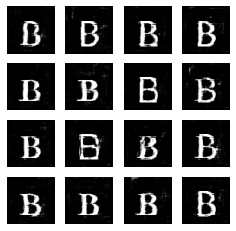

In [26]:
train(train_dataset, EPOCHS)

Now lets restore our checkpoints

In [27]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

<h2>Generating alphabets given a character label</h2>
Let's test our model

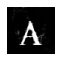

In [39]:
num_examples_to_generate = 1
noise = tf.random.normal([num_examples_to_generate, noise_dim])

# Generate any random character using the below int_labels
# int_labels = np.random.randint(low=1, high=26, size=(1,))
# Generate manually given character label
int_labels = 1
y_train = keras.utils.to_categorical(int_labels, num_classes=total_characters)
y_train = y_train * np.ones([num_examples_to_generate, total_characters])

seed = np.concatenate((noise, y_train), axis=-1)

generate_and_save_images(generator,
                       1000,
                       seed)